# Predicting MLB Pitcher ERA from Climate and Performance Data

Created by Jacob Sii

The inspiration for this project was an infographic of two elite MLB pitchers with highly fluccuating performance metrics correlated to the weather. I wanted to challenge the objectivity of this theory through EDA.

#1. Power Analysis:
This determines the minimum sample size needed to observe a meaningful relationship between weather and performance at a given confidence level.

In [ ]:
from statsmodels.stats.power import FTestPowerF2
power_analysis = FTestPowerF2()

features = 8 # K/9, WHIP, FIP, IP, Temperature, Humidity, Wind Speed, Elevation
sample_size = power_analysis.solve_power(effect_size=0.2, df_num=features, alpha=0.05, power=0.80)
print(f"A model with {features} predictive features should include at least {sample_size} observations.")

A model with 8 predictive features should include at least 74.1762475094884 observations.


#2. Pitcher Stats Extraction
This portion of the notebook extracts per-game pitching statistics for all pitchers from 2022-2025. Statistics include strikeouts, base on balls, homeruns, hits allowed, earned runs, innings pitched, and batters hit by pitch. This raw data is used to compute our predictive features (ERA, K/9, WHIP, FIP).

- ERA = (earned runs / IP) × 9
- K/9 = (strikeouts / IP) × 9
- WHIP = (walks + hits) / IP
- FIP = ((13 × HR) + (3 × (BB + HBP)) − (2 × K)) / IP + 3.17

The FIP constant (≈3.17) scales FIP onto the same range as ERA. Games where the pitcher recorded 0 outs are excluded since per-inning rates are undefined.

We verify that our computed stats fall within expected MLB ranges:

- ERA: Typically 0–27 for a single game (27 = 1 earned run per out)
- K/9: Usually 0–27 (max ~4 K per inning for extra-out situations)
- WHIP: Usually 0–10 for a single appearance
- FIP: Generally -1 to 15 for individual games

In [ ]:
"""
extract_from_mlbapi.py

Extracts per-game pitching stats for all MLB pitchers from 2021-2025.
Computes: ERA, K/9, WHIP, FIP, IP (per game appearance).
Outputs a CSV with one row per pitcher-game, including venue metadata
for downstream weather data joins.

FIP formula: ((13*HR) + (3*(BB+HBP)) - (2*K)) / IP + cFIP
cFIP ≈ 3.17 (approximate league constant; stable across seasons at ~3.1-3.2)
"""

import requests
import pandas as pd
import time
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# ── Configuration ──────────────────────────────────────────────────────────────
SEASONS = range(2022, 2026)          # 2022-2025
SPORT_ID = 1                         # MLB
MAX_WORKERS = 10                     # concurrent API requests
FIP_CONSTANT = 3.17                  # approximate league constant (~3.1-3.2)
OUTPUT_FILE = "pitcher_game_stats_2021_2025.csv"

# ── HTTP Session ───────────────────────────────────────────────────────────────
SESSION = requests.Session()
SESSION.headers.update({"User-Agent": "pitcher-climate-study/1.0"})
TIMEOUT = 20


def api_get(url, retries=3, backoff=0.5):
    """GET request with exponential backoff retry."""
    for attempt in range(retries):
        try:
            resp = SESSION.get(url, timeout=TIMEOUT)
            if resp.ok:
                return resp.json()
        except requests.RequestException:
            pass
        time.sleep(backoff * (2 ** attempt))
    return {}


# ── Team & Roster Helpers ──────────────────────────────────────────────────────

def get_team_ids(season):
    """Return list of MLB team IDs for a given season."""
    url = f"https://statsapi.mlb.com/api/v1/teams?sportId={SPORT_ID}&season={season}"
    return [t["id"] for t in api_get(url).get("teams", [])]


def get_pitcher_ids_for_season(season):
    """
    Return set of pitcher person IDs who appeared on any MLB roster
    in the given season. Uses the 40-man roster to capture pitchers
    who were active at any point during the season.
    """
    pitcher_ids = set()
    for team_id in get_team_ids(season):
        url = (
            f"https://statsapi.mlb.com/api/v1/teams/{team_id}/roster"
            f"?rosterType=fullSeason&season={season}"
        )
        roster = api_get(url).get("roster", [])
        for player in roster:
            pos = player.get("position", {}).get("abbreviation", "")
            if pos == "P":
                pitcher_ids.add(player["person"]["id"])
    return pitcher_ids


def get_all_pitcher_ids():
    """Collect unique pitcher IDs across all seasons."""
    all_ids = set()
    for season in SEASONS:
        print(f"  Fetching rosters for {season}...")
        all_ids |= get_pitcher_ids_for_season(season)
    print(f"  Found {len(all_ids)} unique pitchers across {len(list(SEASONS))} seasons")
    return sorted(all_ids)


# ── Schedule / Venue Map ──────────────────────────────────────────────────────

def build_schedule_map(season):
    """
    Build lookup: gamePk -> (venue_id, venue_name, city, state, game_date_utc, latitude, longitude)
    Hydrates venue location for coordinate data (useful for weather API joins).
    """
    url = (
        f"https://statsapi.mlb.com/api/v1/schedule"
        f"?sportId={SPORT_ID}&season={season}"
        f"&gameType=R,F,D,L,W"
        f"&hydrate=venue(location)"
    )
    data = api_get(url)
    mapping = {}
    for date_entry in data.get("dates", []):
        for game in date_entry.get("games", []):
            game_pk = game.get("gamePk")
            if not game_pk:
                continue
            venue = game.get("venue") or {}
            location = venue.get("location") or {}
            coords = location.get("defaultCoordinates") or {}
            mapping[game_pk] = {
                "venue_id": venue.get("id"),
                "venue_name": venue.get("name"),
                "city": location.get("city", ""),
                "state": location.get("stateAbbrev") or location.get("state", ""),
                "game_date_utc": game.get("gameDate"),
                "latitude": coords.get("latitude"),
                "longitude": coords.get("longitude"),
            }
    return mapping


def build_all_schedule_maps():
    """Pre-build schedule maps for all seasons."""
    maps = {}
    for season in SEASONS:
        print(f"  Building schedule map for {season}...")
        maps[season] = build_schedule_map(season)
    return maps


# ── Player Name Cache ─────────────────────────────────────────────────────────

NAME_CACHE = {}

def get_pitcher_name(person_id):
    """Fetch and cache a pitcher's full name."""
    if person_id in NAME_CACHE:
        return NAME_CACHE[person_id]
    url = f"https://statsapi.mlb.com/api/v1/people/{person_id}"
    people = api_get(url).get("people", [])
    name = people[0]["fullName"] if people else str(person_id)
    NAME_CACHE[person_id] = name
    return name


# ── Stat Computation ──────────────────────────────────────────────────────────

def parse_ip(ip_str):
    """
    Convert MLB innings pitched string to float.
    MLB uses .1 = 1/3 inning, .2 = 2/3 inning.
    e.g. '6.2' -> 6.667
    """
    if not ip_str:
        return 0.0
    parts = str(ip_str).split(".")
    whole = int(parts[0])
    thirds = int(parts[1]) if len(parts) > 1 else 0
    return whole + (thirds / 3.0)


def compute_game_stats(stat_dict, ip_float):
    """
    Compute per-game pitching metrics from raw API stat fields.

    Returns dict with: ip, era, k_per_9, whip, fip
    """
    # Raw counts from API
    earned_runs = stat_dict.get("earnedRuns", 0)
    strikeouts = stat_dict.get("strikeOuts", 0)
    walks = stat_dict.get("baseOnBalls", 0)
    hits = stat_dict.get("hits", 0)
    home_runs = stat_dict.get("homeRuns", 0)
    hbp = stat_dict.get("hitBatsmen", 0)

    # ERA = (earned runs / IP) * 9
    era = (earned_runs * 9.0) / ip_float

    # K/9 = (strikeouts / IP) * 9
    k_per_9 = (strikeouts * 9.0) / ip_float

    # WHIP = (walks + hits) / IP
    whip = (walks + hits) / ip_float

    # FIP = ((13*HR) + (3*(BB+HBP)) - (2*K)) / IP + cFIP
    fip = ((13 * home_runs) + (3 * (walks + hbp)) - (2 * strikeouts)) / ip_float + FIP_CONSTANT

    return {
        "ip": round(ip_float, 3),
        "earned_runs": earned_runs,
        "strikeouts": strikeouts,
        "walks": walks,
        "hits_allowed": hits,
        "home_runs_allowed": home_runs,
        "hit_by_pitch": hbp,
        "era": round(era, 3),
        "k_per_9": round(k_per_9, 3),
        "whip": round(whip, 3),
        "fip": round(fip, 3),
    }


# ── Per-Pitcher Extraction ────────────────────────────────────────────────────

def extract_pitcher_games(pitcher_id, schedule_maps):
    """
    Pull game logs for one pitcher across all seasons.
    Returns list of row dicts.
    """
    name = get_pitcher_name(pitcher_id)
    rows = []

    for season in SEASONS:
        url = (
            f"https://statsapi.mlb.com/api/v1/people/{pitcher_id}/stats"
            f"?stats=gameLog&group=pitching&season={season}"
        )
        data = api_get(url).get("stats", [])
        splits = data[0].get("splits", []) if data else []
        sched = schedule_maps[season]

        for split in splits:
            stat = split.get("stat", {})
            ip_float = parse_ip(stat.get("inningsPitched", "0"))

            # Skip appearances with 0 IP (no outs recorded)
            if ip_float == 0:
                continue

            game_pk = (split.get("game") or {}).get("gamePk")
            if not game_pk:
                continue

            venue_info = sched.get(game_pk, {})
            if not venue_info.get("venue_name") or not venue_info.get("game_date_utc"):
                continue

            # Compute all stats
            stats = compute_game_stats(stat, ip_float)

            rows.append({
                "pitcher_id": pitcher_id,
                "pitcher_name": name,
                "season": season,
                "game_pk": game_pk,
                "game_date_utc": venue_info["game_date_utc"],
                "venue_name": venue_info["venue_name"],
                "venue_city": venue_info["city"],
                "venue_state": venue_info["state"],
                "latitude": venue_info.get("latitude"),
                "longitude": venue_info.get("longitude"),
                **stats,
            })

    return rows


# ── Main ──────────────────────────────────────────────────────────────────────

def main():
    print("=" * 60)
    print("MLB Pitcher Game Stats Extraction (2021-2025)")
    print("=" * 60)

    # Step 1: Build schedule maps (venue + location data)
    print("\n[1/3] Building season schedule maps...")
    schedule_maps = build_all_schedule_maps()

    # Step 2: Collect all pitcher IDs
    print("\n[2/3] Collecting pitcher IDs from rosters...")
    pitcher_ids = get_all_pitcher_ids()

    # Step 3: Extract game logs concurrently
    print(f"\n[3/3] Extracting game logs for {len(pitcher_ids)} pitchers...")
    all_rows = []

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = {
            executor.submit(extract_pitcher_games, pid, schedule_maps): pid
            for pid in pitcher_ids
        }
        for future in tqdm(as_completed(futures), total=len(futures), desc="Pitchers"):
            try:
                all_rows.extend(future.result())
            except Exception as e:
                pid = futures[future]
                print(f"\n  Warning: failed for pitcher {pid}: {e}")

    # Build DataFrame and save
    df = pd.DataFrame(all_rows)
    df = df.sort_values(["pitcher_name", "game_date_utc"]).reset_index(drop=True)
    df.to_csv(OUTPUT_FILE, index=False)

    print(f"\n{'=' * 60}")
    print(f"Done! Saved to {OUTPUT_FILE}")
    print(f"  Rows:     {len(df):,}")
    print(f"  Pitchers: {df['pitcher_id'].nunique():,}")
    print(f"  Seasons:  {sorted(df['season'].unique())}")
    print(f"\nColumns: {list(df.columns)}")
    print(f"\nSample:\n{df.head()}")

    return df


if __name__ == "__main__":
    df = main()

MLB Pitcher Game Stats Extraction (2021-2025)

[1/3] Building season schedule maps...
  Building schedule map for 2022...
  Building schedule map for 2023...
  Building schedule map for 2024...
  Building schedule map for 2025...

[2/3] Collecting pitcher IDs from rosters...
  Fetching rosters for 2022...
  Fetching rosters for 2023...
  Fetching rosters for 2024...
  Fetching rosters for 2025...
  Found 1336 unique pitchers across 4 seasons

[3/3] Extracting game logs for 1336 pitchers...


Pitchers: 100%|██████████| 1336/1336 [01:03<00:00, 20.88it/s]



Done! Saved to pitcher_game_stats_2021_2025.csv
  Rows:     81,764
  Pitchers: 1,336
  Seasons:  [np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]

Columns: ['pitcher_id', 'pitcher_name', 'season', 'game_pk', 'game_date_utc', 'venue_name', 'venue_city', 'venue_state', 'latitude', 'longitude', 'ip', 'earned_runs', 'strikeouts', 'walks', 'hits_allowed', 'home_runs_allowed', 'hit_by_pitch', 'era', 'k_per_9', 'whip', 'fip']

Sample:
   pitcher_id pitcher_name  season  game_pk  ...      era k_per_9    whip     fip
0      669935   A.J. Alexy    2022   661810  ...   13.500   9.000   3.000   5.670
1      669935   A.J. Alexy    2022   661658  ...    0.000   3.857   0.857   3.599
2      669935   A.J. Alexy    2022   663212  ...    7.714   7.714   3.000   9.599
3      669935   A.J. Alexy    2022   661419  ...  108.000  27.000  12.000  24.170
4      607609  A.J. Ladwig    2022   661360  ...   10.800   0.000   1.800  10.970

[5 rows x 21 columns]


#3. Weather Data Extraction


In [ ]:
"""
extract_weather_data.py

Pulls historical weather data from the Open-Meteo Archive API for each
unique game location + date in the pitcher stats dataset.

Climate features extracted (aligned with power analysis):
    - temperature (°F at game time)
    - humidity (% at game time)
    - wind_speed (mph at game time)
    - elevation (ft above sea level, per venue)

Approach:
    - Deduplicate games by (game_pk, latitude, longitude, game_date)
      so we only make one API call per unique venue-date combination
    - Pull hourly weather for each game date
    - Select the hour closest to typical first pitch (~7 PM local)
    - Merge weather back onto every pitcher appearance for that game

Outputs: weather_by_game.csv (one row per unique game)
"""

import pandas as pd
import numpy as np
import requests
import time
from tqdm import tqdm

# ── Configuration ──────────────────────────────────────────────────────────────
PITCHER_STATS_FILE = "pitcher_game_stats_2021_2025.csv"
OUTPUT_FILE = "weather_by_game.csv"
OPEN_METEO_URL = "https://archive-api.open-meteo.com/v1/archive"

# Weather variables to request (order matters for parsing)
HOURLY_VARIABLES = [
    "temperature_2m",          # °C -> convert to °F
    "relative_humidity_2m",    # %
    "wind_speed_10m",          # km/h -> convert to mph
]

# Typical MLB first pitch hour in UTC
# Most games start 7 PM ET = 23:00 UTC (night) or 1 PM ET = 17:00 UTC (day)
# We'll pick the closest hour to the actual game time from the data
DEFAULT_GAME_HOUR_UTC = 23

# Unit conversions
C_TO_F = lambda c: (c * 9 / 5) + 32
KMH_TO_MPH = lambda k: k * 0.621371
M_TO_FT = lambda m: m * 3.28084

# Rate limiting: Open-Meteo free tier allows ~10,000 calls/day
REQUEST_DELAY = 0.25  # seconds between requests

# ── HTTP Session ───────────────────────────────────────────────────────────────
SESSION = requests.Session()
SESSION.headers.update({"User-Agent": "pitcher-climate-study/1.0"})


def api_get(url, params, retries=3, backoff=1.0):
    """GET with retry and backoff."""
    for attempt in range(retries):
        try:
            resp = SESSION.get(url, params=params, timeout=30)
            if resp.ok:
                return resp.json()
            elif resp.status_code == 429:
                # Rate limited — wait longer
                time.sleep(backoff * (2 ** attempt) * 5)
            else:
                resp.raise_for_status()
        except requests.RequestException as e:
            if attempt == retries - 1:
                print(f"  Failed after {retries} retries: {e}")
            time.sleep(backoff * (2 ** attempt))
    return None


# ── Game Deduplication ─────────────────────────────────────────────────────────

def get_unique_games(df):
    """
    Extract unique game-venue-date combinations from pitcher stats.
    This avoids redundant API calls — if 10 pitchers appeared in the
    same game, we only need weather data once for that game.
    """
    # Parse game date (just the date portion, not full datetime)
    df = df.copy()
    df["game_date"] = pd.to_datetime(df["game_date_utc"]).dt.date
    df["game_hour_utc"] = pd.to_datetime(df["game_date_utc"]).dt.hour

    games = (
        df.groupby("game_pk")
        .agg({
            "game_date": "first",
            "game_hour_utc": "first",
            "venue_name": "first",
            "venue_city": "first",
            "venue_state": "first",
            "latitude": "first",
            "longitude": "first",
        })
        .reset_index()
    )

    # Drop games missing coordinates
    before = len(games)
    games = games.dropna(subset=["latitude", "longitude"])
    dropped = before - len(games)
    if dropped > 0:
        print(f"  Dropped {dropped} games with missing coordinates")

    print(f"  {len(games)} unique games to fetch weather for")
    return games


# ── Weather Fetching ───────────────────────────────────────────────────────────

def fetch_game_weather(lat, lon, game_date, game_hour_utc=None):
    """
    Fetch hourly weather for a single location and date from Open-Meteo.
    Returns dict with weather values at the hour closest to game time,
    plus elevation.

    Returns None on failure.
    """
    date_str = str(game_date)
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": date_str,
        "end_date": date_str,
        "hourly": ",".join(HOURLY_VARIABLES),
        "temperature_unit": "celsius",
        "wind_speed_unit": "kmh",
    }

    data = api_get(OPEN_METEO_URL, params)
    if not data or "hourly" not in data:
        return None

    hourly = data["hourly"]
    times = hourly.get("time", [])
    if not times:
        return None

    # Determine which hour to use
    target_hour = game_hour_utc if game_hour_utc else DEFAULT_GAME_HOUR_UTC

    # Find the index of the closest hour
    hours = [int(t.split("T")[1].split(":")[0]) for t in times]
    best_idx = min(range(len(hours)), key=lambda i: abs(hours[i] - target_hour))

    # Extract values at game time
    temp_c = hourly.get("temperature_2m", [None])[best_idx]
    humidity = hourly.get("relative_humidity_2m", [None])[best_idx]
    wind_kmh = hourly.get("wind_speed_10m", [None])[best_idx]

    # Elevation comes from the top-level response (meters)
    elevation_m = data.get("elevation")

    # Convert units
    result = {
        "temperature_f": round(C_TO_F(temp_c), 1) if temp_c is not None else None,
        "humidity_pct": humidity,
        "wind_speed_mph": round(KMH_TO_MPH(wind_kmh), 1) if wind_kmh is not None else None,
        "elevation_ft": round(M_TO_FT(elevation_m), 1) if elevation_m is not None else None,
        "weather_hour_utc": hours[best_idx],
    }

    return result


def fetch_all_game_weather(games_df):
    """
    Fetch weather for all unique games. Returns DataFrame with weather columns.
    """
    weather_rows = []

    for _, game in tqdm(games_df.iterrows(), total=len(games_df), desc="Fetching weather"):
        weather = fetch_game_weather(
            lat=game["latitude"],
            lon=game["longitude"],
            game_date=game["game_date"],
            game_hour_utc=game.get("game_hour_utc"),
        )

        row = {"game_pk": game["game_pk"]}

        if weather:
            row.update(weather)
        else:
            row.update({
                "temperature_f": None,
                "humidity_pct": None,
                "wind_speed_mph": None,
                "elevation_ft": None,
                "weather_hour_utc": None,
            })

        weather_rows.append(row)

        # Rate limiting
        time.sleep(REQUEST_DELAY)

    return pd.DataFrame(weather_rows)


# ── Main ──────────────────────────────────────────────────────────────────────

def main():
    print("=" * 60)
    print("Weather Data Extraction for Pitcher-Climate Study")
    print("=" * 60)

    # Step 1: Load pitcher stats
    print("\n[1/4] Loading pitcher game stats...")
    pitcher_df = pd.read_csv(PITCHER_STATS_FILE)
    print(f"  {len(pitcher_df):,} pitcher appearances loaded")

    # Step 2: Deduplicate to unique games
    print("\n[2/4] Identifying unique games...")
    games = get_unique_games(pitcher_df)

    # Step 3: Fetch weather for each game
    print("\n[3/4] Fetching weather data from Open-Meteo...")
    weather_df = fetch_all_game_weather(games)

    # Step 4: Save and report
    print("\n[4/4] Saving results...")
    weather_df.to_csv(OUTPUT_FILE, index=False)

    # Summary stats
    total = len(weather_df)
    complete = weather_df.dropna(subset=["temperature_f"]).shape[0]
    missing = total - complete

    print(f"\n{'=' * 60}")
    print(f"Done! Saved to {OUTPUT_FILE}")
    print(f"  Total games:   {total:,}")
    print(f"  With weather:  {complete:,}")
    print(f"  Missing:       {missing:,}")
    print(f"\nWeather summary:")
    print(weather_df[["temperature_f", "humidity_pct", "wind_speed_mph", "elevation_ft"]].describe())

    return weather_df


if __name__ == "__main__":
    weather_df = main()

Weather Data Extraction for Pitcher-Climate Study

[1/4] Loading pitcher game stats...
  81,764 pitcher appearances loaded

[2/4] Identifying unique games...
  Dropped 4 games with missing coordinates
  9715 unique games to fetch weather for

[3/4] Fetching weather data from Open-Meteo...


Fetching weather: 100%|██████████| 9715/9715 [1:30:39<00:00,  1.79it/s]


[4/4] Saving results...

Done! Saved to weather_by_game.csv
  Total games:   9,715
  With weather:  9,668
  Missing:       47

Weather summary:
       temperature_f  humidity_pct  wind_speed_mph  elevation_ft
count    9668.000000   9668.000000     9668.000000   9668.000000
mean       74.639574     55.916115        8.292439    526.531930
std        12.444427     18.702378        4.046221    933.411839
min        32.200000      2.000000        0.000000    -19.700000
25%        66.900000     43.000000        5.400000     29.500000
50%        75.700000     57.000000        7.800000    479.000000
75%        83.100000     70.000000       10.600000    629.900000
max       114.100000    100.000000       29.300000   5190.300000


#4. Clean and Unify Data

Merge the data by pairing weather data with the park each game was played at.

In [ ]:
pitcher_data = pd.read_csv('pitcher_game_stats_2021_2025.csv')
weather_data = pd.read_csv('weather_by_game.csv')
complete_data = pitcher_data.merge(weather_data, on='game_pk', how='left')

print(f"Rows: {len(complete_data)}")
print(f"Null weather rows: {complete_data['temperature_f'].isna().sum()}")

Rows: 81764
Null weather rows: 447


Drop rows where weather data is missing.

In [ ]:
complete_data = complete_data.dropna(subset=['temperature_f', 'humidity_pct', 'wind_speed_mph', 'elevation_ft'])

print(f"Rows: {len(complete_data)}")

Rows: 81317


Save this as the final dataset.

In [ ]:
complete_data.to_csv('pitcher_climate_merged.csv', index=False)

#5. Exploratory Data Analysis

We start by verifying the datasets merged properly, explore the distributions of our features, and look for relationships between climate data and performance.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 120

df = pd.read_csv("pitcher_climate_merged.csv")
print(f"Dataset: {len(df):,} rows × {df.shape[1]} columns")
df.head()

Dataset: 81,317 rows × 26 columns


,pitcher_id,pitcher_name,season,game_pk,game_date_utc,venue_name,venue_city,venue_state,latitude,longitude,ip,earned_runs,strikeouts,walks,hits_allowed,home_runs_allowed,hit_by_pitch,era,k_per_9,whip,fip,temperature_f,humidity_pct,wind_speed_mph,elevation_ft,weather_hour_utc
0,669935,A.J. Alexy,2022,661810,2022-07-16T00:05:00Z,Globe Life Field,Arlington,TX,32.747299,-97.081818,2.000,3,2,3,3,0,0,13.500,9.000,3.000,5.670,99.1,31.0,6.8,593.8,23.0
1,669935,A.J. Alexy,2022,661658,2022-08-22T23:10:00Z,Target Field,Minneapolis,MN,44.981829,-93.277891,2.333,0,1,1,1,0,0,0.000,3.857,0.857,3.599,78.6,45.0,4.0,836.6,23.0
2,669935,A.J. Alexy,2022,663212,2022-09-02T23:10:00Z,Fenway Park,Boston,MA,42.346456,-71.097441,2.333,2,2,2,5,1,0,7.714,7.714,3.000,9.599,65.8,60.0,7.2,13.1,23.0
3,669935,A.J. Alexy,2022,661419,2022-09-12T23:10:00Z,loanDepot park,Miami,FL,25.777962,-80.219518,0.333,4,1,3,1,0,0,108.000,27.000,12.000,24.170,77.0,87.0,3.6,3.3,23.0
4,607609,A.J. Ladwig,2022,661360,2022-08-13T23:10:00Z,loanDepot park,Miami,FL,25.777962,-80.219518,3.333,4,0,0,6,2,0,10.800,0.000,1.800,10.970,80.2,79.0,7.1,3.3,23.0


Lets first check for missing values, establish data types, and get a summary of statistics. This way we catch games that were missing weather data or extreme stat lines from extremely short outings.

In [ ]:
print("Data types:")
print(df.dtypes)
print(f"\nNull counts:\n{df.isnull().sum()}")
print(f"\nShape: {df.shape}")

# Key columns to inspect
stat_cols = ["era", "k_per_9", "whip", "fip", "ip", "temperature_f", "humidity_pct", "wind_speed_mph", "elevation_ft"]

df[stat_cols].describe().round(2)

Data types:
pitcher_id             int64
pitcher_name          object
season                 int64
game_pk                int64
game_date_utc         object
venue_name            object
venue_city            object
venue_state           object
latitude             float64
longitude            float64
ip                   float64
earned_runs            int64
strikeouts             int64
walks                  int64
hits_allowed           int64
home_runs_allowed      int64
hit_by_pitch           int64
era                  float64
k_per_9              float64
whip                 float64
fip                  float64
temperature_f        float64
humidity_pct         float64
wind_speed_mph       float64
elevation_ft         float64
weather_hour_utc     float64
dtype: object

Null counts:
pitcher_id            0
pitcher_name          0
season                0
game_pk               0
game_date_utc         0
venue_name            0
venue_city            0
venue_state          87
latitude      

,era,k_per_9,whip,fip,ip,temperature_f,humidity_pct,wind_speed_mph,elevation_ft
count,81317.0,81317.00,81317.00,81317.00,81317.00,81317.00,81317.00,81317.00,81317.00
mean,5.2,9.06,1.52,4.54,2.10,74.60,55.94,8.30,528.89
std,12.3,7.39,1.83,6.67,1.94,12.48,18.73,4.06,939.26
min,0.0,0.00,0.00,-5.83,0.33,32.20,2.00,0.00,-19.70
25%,0.0,3.00,0.43,1.17,1.00,66.90,43.00,5.40,29.50
50%,0.0,9.00,1.00,3.17,1.00,75.70,57.00,7.80,479.00
75%,6.0,13.50,2.00,5.67,2.67,83.10,70.00,10.60,629.90
max,216.0,54.00,27.00,138.17,9.00,114.10,100.00,29.30,5190.30


Pitcher outings where few outs were recorded produce extreme per-game ratio stats. i.e. A reliever allows 2 earned runs and gets pulled after recording only 1 out (0.1 IP) has an ERA of 54.00 for that game. The calcualtion is correct but this is not meaningful for our model. We will filter to games with at least 3.0 IP to emphasize games with enough data maintain stable ratios.

In [ ]:
print(f"Before filter: {len(df):,} rows")
print(f"IP distribution (pre-filter):")
print(df["ip"].describe().round(2))

df = df[df["ip"] >= 3.0].copy()

print(f"\nAfter filter (IP >= 3.0): {len(df):,} rows")
print(f"ERA range after filter: {df['era'].min():.2f} – {df['era'].max():.2f}")

Before filter: 81,317 rows
IP distribution (pre-filter):
count    81317.00
mean         2.10
std          1.94
min          0.33
25%          1.00
50%          1.00
75%          2.67
max          9.00
Name: ip, dtype: float64

After filter (IP >= 3.0): 19,886 rows
ERA range after filter: 0.00 – 33.00


Now lets plot the distributions of our prediction target (ERA) and the predictor features to understand their shape and spot any outliers.

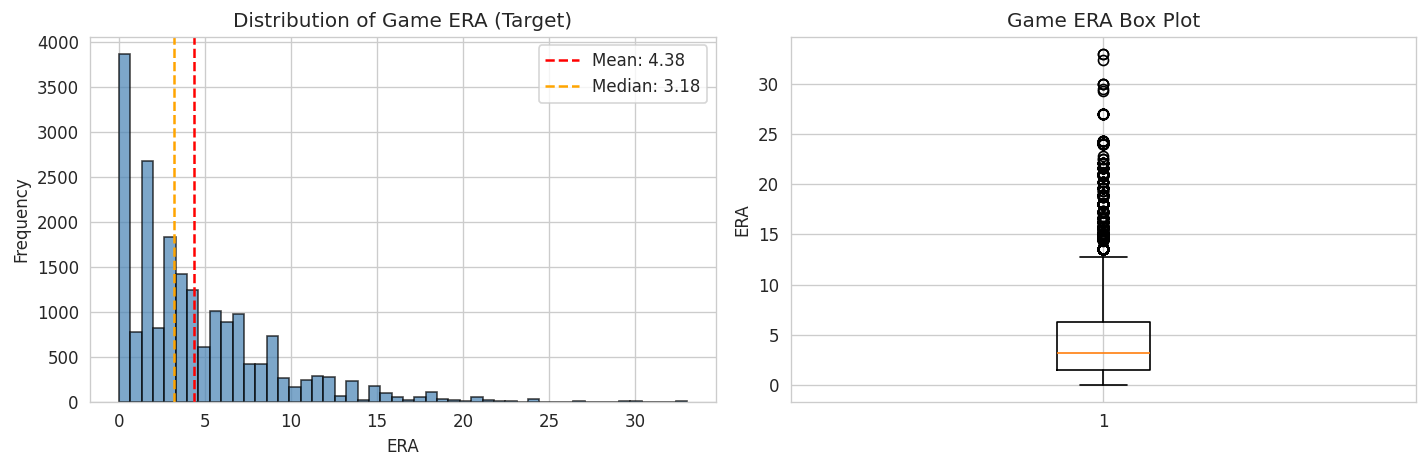

ERA skewness: 1.50
ERA kurtosis: 3.00


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ERA histogram
axes[0].hist(df["era"], bins=50, edgecolor="black", alpha=0.7, color="steelblue")
axes[0].axvline(df["era"].mean(), color="red", linestyle="--", label=f'Mean: {df["era"].mean():.2f}')
axes[0].axvline(df["era"].median(), color="orange", linestyle="--", label=f'Median: {df["era"].median():.2f}')
axes[0].set_title("Distribution of Game ERA (Target)")
axes[0].set_xlabel("ERA")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# ERA box plot
axes[1].boxplot(df["era"], vert=True)
axes[1].set_title("Game ERA Box Plot")
axes[1].set_ylabel("ERA")

plt.tight_layout()
plt.show()

print(f"ERA skewness: {df['era'].skew():.2f}")
print(f"ERA kurtosis: {df['era'].kurtosis():.2f}")

We see that ERA is skewed right but this is expected as most pitchers fall in the 0 to 6 ERA range. The skew is not enough to require a tranformation.

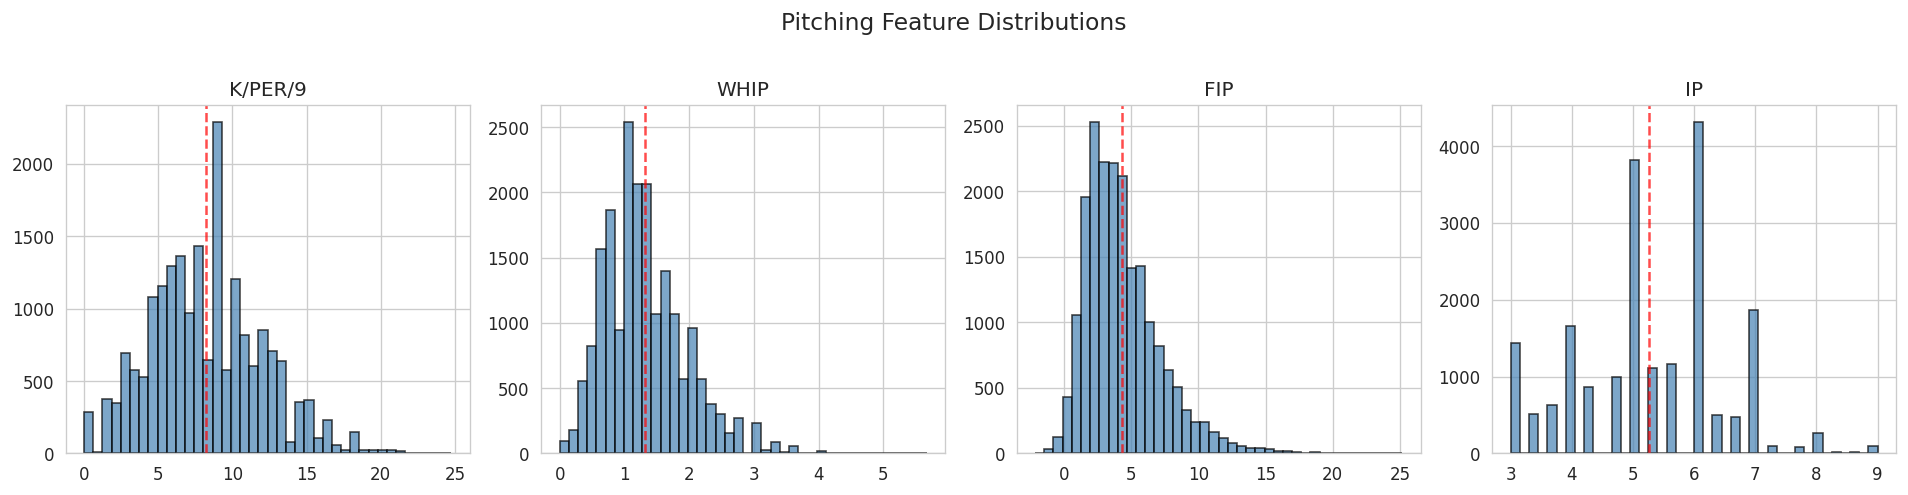

In [ ]:
pitching_features = ["k_per_9", "whip", "fip", "ip"]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for ax, col in zip(axes, pitching_features):
    ax.hist(df[col], bins=40, edgecolor="black", alpha=0.7, color="steelblue")
    ax.axvline(df[col].mean(), color="red", linestyle="--", alpha=0.7)
    ax.set_title(col.upper().replace("_", "/"))
    ax.set_xlabel("")

fig.suptitle("Pitching Feature Distributions", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


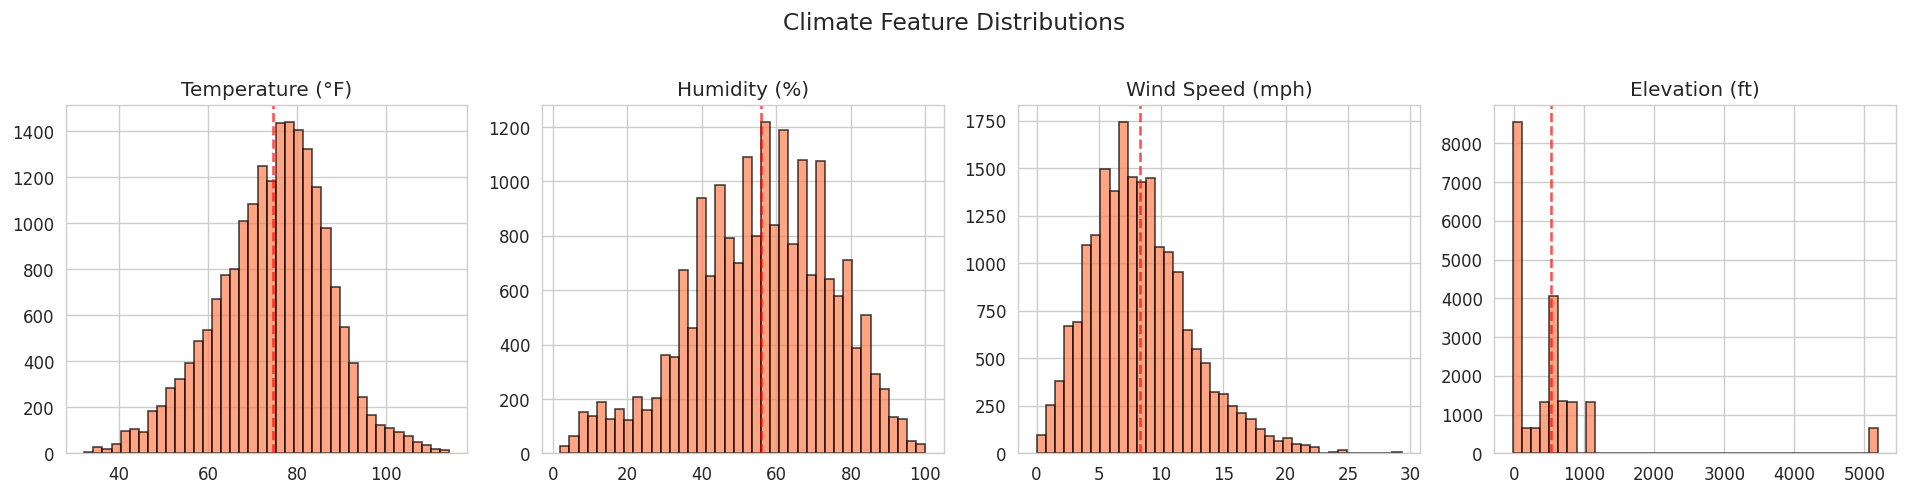

In [ ]:
climate_features = ["temperature_f", "humidity_pct", "wind_speed_mph", "elevation_ft"]
climate_labels = ["Temperature (°F)", "Humidity (%)", "Wind Speed (mph)", "Elevation (ft)"]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for ax, col, label in zip(axes, climate_features, climate_labels):
    ax.hist(df[col], bins=40, edgecolor="black", alpha=0.7, color="coral")
    ax.axvline(df[col].mean(), color="red", linestyle="--", alpha=0.7)
    ax.set_title(label)
    ax.set_xlabel("")

fig.suptitle("Climate Feature Distributions", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

- Temperature: normal distribution centered around 75°F which is standard for April-October
- Humidity: roughly normal and centered around 60% humidity
- Wind speed: right-skewed as most games have moderate wind conditions
- Elevation: clustered with most observations near sea level but outlier around 5,000 ft for Coors Field in Denver, CO. There is very little variance here but it accurately represents the effect elevation has on ball flight.

Now we search for any indicators of a relationship between the climate and performance. We will use scatter plots with trend lines and binned averages to search for patterns.

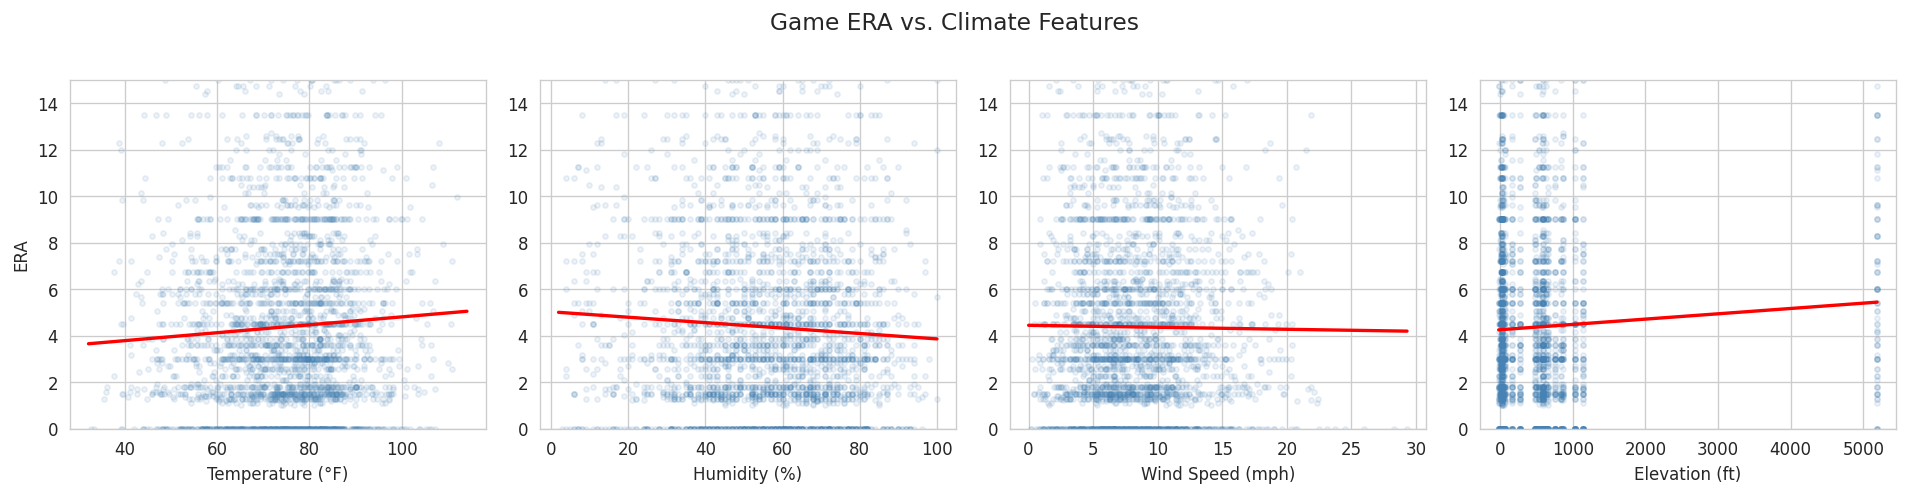

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for ax, col, label in zip(axes, climate_features, climate_labels):
    # Sample for cleaner scatter (full dataset is dense)
    sample = df.sample(min(3000, len(df)), random_state=42)
    ax.scatter(sample[col], sample["era"], alpha=0.1, s=10, color="steelblue")

    # Trend line
    z = np.polyfit(df[col].dropna(), df.loc[df[col].notna(), "era"], 1)
    p = np.poly1d(z)
    x_range = np.linspace(df[col].min(), df[col].max(), 100)
    ax.plot(x_range, p(x_range), color="red", linewidth=2)

    ax.set_xlabel(label)
    ax.set_ylabel("ERA" if col == climate_features[0] else "")
    ax.set_ylim(0, 15)

fig.suptitle("Game ERA vs. Climate Features", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

The scatter plots appear noisy due to the volume and fluccuations of individual game performances. The trend lines give us hints at the direction of the relationships. We'll get a better look at the patterns by binning each climate feature into quantiles and compare the mean ERA across the bins.

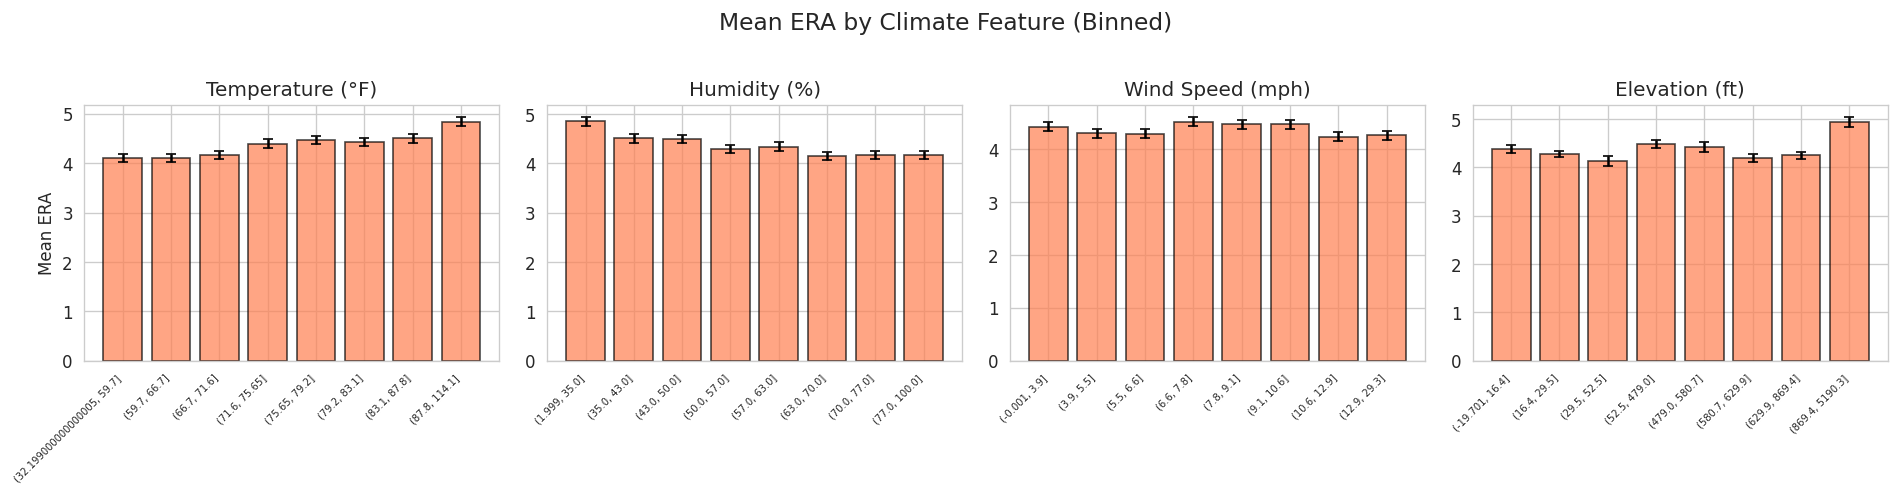

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for ax, col, label in zip(axes, climate_features, climate_labels):
    # Create 8 bins based on quantiles
    df["_bin"] = pd.qcut(df[col], q=8, duplicates="drop")
    binned = df.groupby("_bin", observed=True)["era"].agg(["mean", "sem"]).reset_index()

    # Plot with error bars
    x_pos = range(len(binned))
    ax.bar(x_pos, binned["mean"], yerr=binned["sem"],
           color="coral", edgecolor="black", alpha=0.7, capsize=3)
    ax.set_xticks(x_pos)
    ax.set_xticklabels([str(b) for b in binned["_bin"]], rotation=45, ha="right", fontsize=6)
    ax.set_ylabel("Mean ERA" if col == climate_features[0] else "")
    ax.set_title(label)

df.drop(columns=["_bin"], inplace=True)

fig.suptitle("Mean ERA by Climate Feature (Binned)", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

The binned analysis gives a more clear view of the the relationships. The error bars, which represent standard error of the mean, show more meaning when the bars do not overlap between bins.

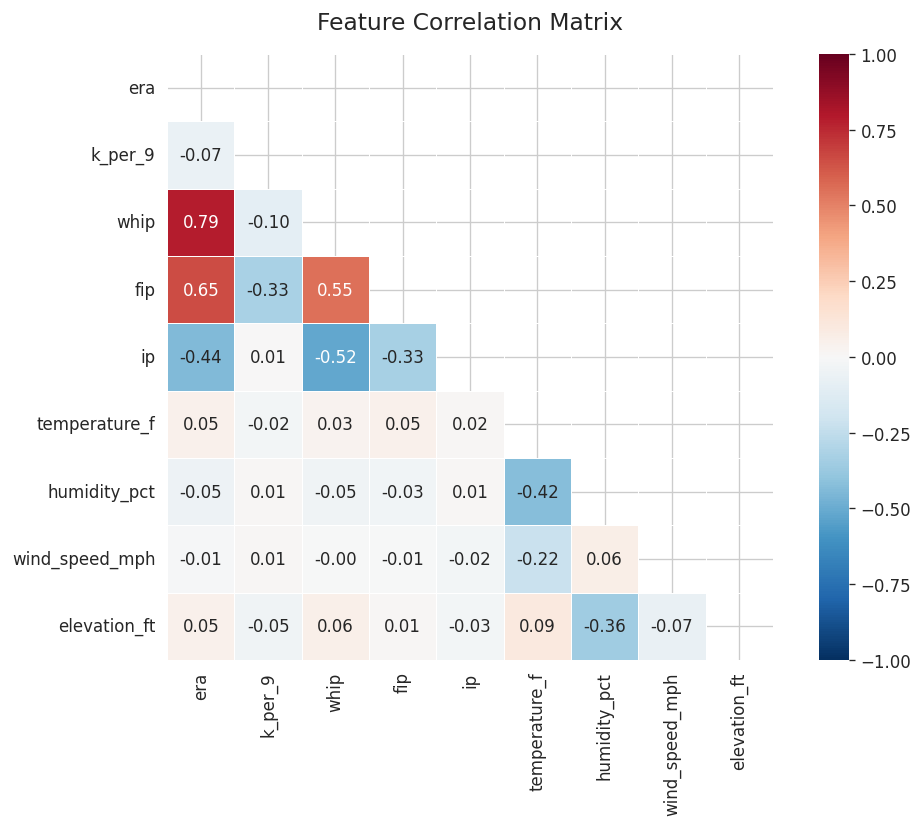

In [ ]:
corr_cols = ["era", "k_per_9", "whip", "fip", "ip",
             "temperature_f", "humidity_pct", "wind_speed_mph", "elevation_ft"]

corr_matrix = df[corr_cols].corr()

fig, ax = plt.subplots(figsize=(9, 7))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    ax=ax,
)
ax.set_title("Feature Correlation Matrix", fontsize=14, pad=15)
plt.tight_layout()
plt.show()

Key Takeways:

Pitching:
- ERA and FIP are positively correlated as expected considering an increase in either implies poor pitching performance. We will include both as FIP isolates the pitchers actions while ERA is the actual outcome.
- K/9 is negatively correlated with ERA because more strikeout leads to less runs scored.
- WHIP is positively correlated with ERA because more baserunners increase the likelyhood somebody will score.

Climate:
- Climate features have little to know correlation with eachother which is a good sign for maintaining independence.
- The correlation between climate and ERA are small. Weather affects pitching minimally according to this matrix but we will measure their value based on how they affect they improve the model compared to a pitching stas only baseline.

Coors Field (Denver, CO) is the highest elevated park by a large margin leading to offense inflation. Let's confirm this.

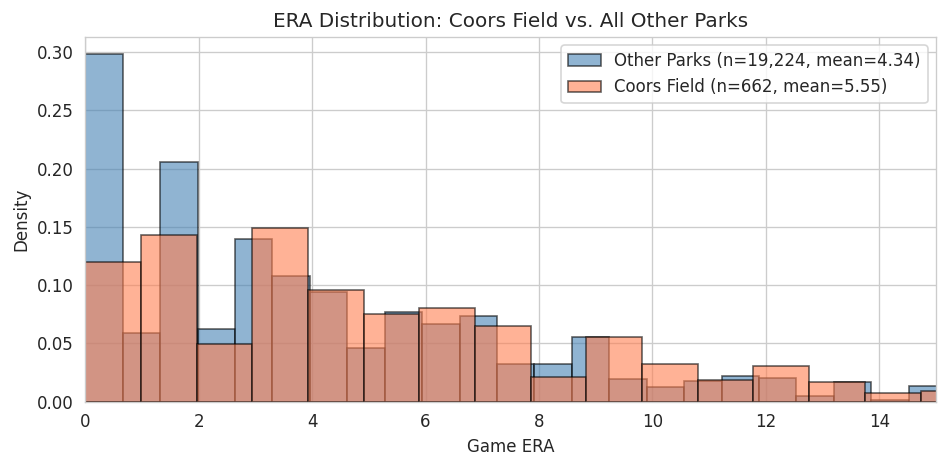

Welch's t-test: t=6.494, p=0.0000
Coors mean ERA:     5.552
Non-Coors mean ERA: 4.336


In [ ]:
coors = df[df["elevation_ft"] > 5000]
non_coors = df[df["elevation_ft"] <= 5000]

fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(non_coors["era"], bins=50, alpha=0.6, color="steelblue",
        label=f'Other Parks (n={len(non_coors):,}, mean={non_coors["era"].mean():.2f})',
        density=True, edgecolor="black")
ax.hist(coors["era"], bins=30, alpha=0.6, color="coral",
        label=f'Coors Field (n={len(coors):,}, mean={coors["era"].mean():.2f})',
        density=True, edgecolor="black")

ax.set_xlabel("Game ERA")
ax.set_ylabel("Density")
ax.set_title("ERA Distribution: Coors Field vs. All Other Parks")
ax.legend()
ax.set_xlim(0, 15)

plt.tight_layout()
plt.show()

# Statistical test
from scipy import stats
t_stat, p_val = stats.ttest_ind(coors["era"], non_coors["era"], equal_var=False)
print(f"Welch's t-test: t={t_stat:.3f}, p={p_val:.4f}")
print(f"Coors mean ERA:     {coors['era'].mean():.3f}")
print(f"Non-Coors mean ERA: {non_coors['era'].mean():.3f}")

This visualization confirms Coors Field inflates scoring confirming the elevation feature embodies the idea that thinner air redices pitch movement and allows the ball to carry farther.

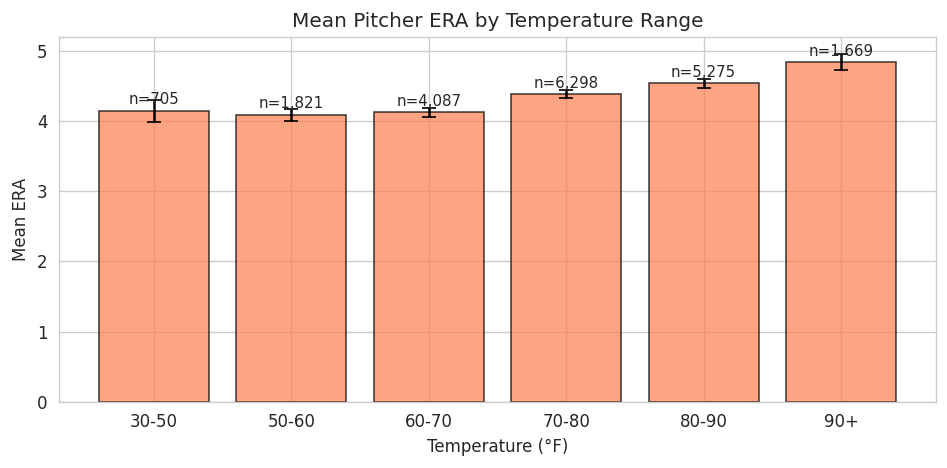

In [ ]:
temp_bins = pd.cut(df["temperature_f"], bins=[30, 50, 60, 70, 80, 90, 110],
                   labels=["30-50", "50-60", "60-70", "70-80", "80-90", "90+"])

temp_summary = df.groupby(temp_bins, observed=True)["era"].agg(["mean", "sem", "count"])

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(temp_summary.index, temp_summary["mean"], yerr=temp_summary["sem"],
              color="coral", edgecolor="black", alpha=0.7, capsize=4)

# Add sample size labels
for bar, count in zip(bars, temp_summary["count"]):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05,
            f'n={count:,}', ha="center", va="bottom", fontsize=9)

ax.set_xlabel("Temperature (°F)")
ax.set_ylabel("Mean ERA")
ax.set_title("Mean Pitcher ERA by Temperature Range")

plt.tight_layout()
plt.show()

The temperature graphic clearly represents another physical behavior of warmer air being less dense affecting pitch movement and ball carry.

## Summary:

**Data Quality:**
After filtering out games where the pitcher did not complete at least three innings and minimizing missing values we have a clean data set prepared for modeling.

**Feature Distributions:**
Pitching stats are distributed as predicted and climate features show reasonable variance for the baseball season months. Elevation is the least variable is known to have the largest affect on performance.

**Climate Signals:**
Climate features show small directional relationships with ERA. Elevation is the most signifacnt as shown by the Coors Park analysis. Temperature, humidity, and wind show weaker patterns.

**Multicollinearity:**
Climate features are mostly independent of eachother as demonstrated in the feature correlation matrix which is ideal for our regression model. Pitching features are correlated considering they are derived from the same raw statistics but represent different aspects of their performance.

**Modeling Approach:**
Considering the noise introduced by single-game performances we expect the model to be mostly influenced by pitcher stats with slight improvement from the climate features. We will quantify this by comparing an XGBoost model trained with pitching stats only to a model trained with pitching and climate features.

#6. Feature Engineering

Giving the model information it would not have access to at prediction time is known as data leakage. This could lead to inaccurate measurements of accuracy. We can't use the pitchers stats from the current game to predict their ERA for the same game. To avoid this we will use rolling historical averages from all pitcher's prior performances.

The model will have access to:
- rolling_era - average ERA across all previous games
- rolling_k_per_9 - historical strikeout rate
- rolling_whip - historical walks + hits per inning
- rolling_fip - historical fielding independent pitching
- rolling_ip - average innings pitched per game

We use shift(1) to excluse the current game and expanding.mean() to compute a cumulative average of all games in the data set. This leads to the rolling stats stabilizing as the season progresses and more games are added. Mid-season games will have much less noisy rolling statistics.

Note: Each pitcher's first game is dropped due to no prior data to compute rolling stats on.

In [101]:
# Sort chronologically per pitcher
df = df.sort_values(["pitcher_id", "game_date_utc"]).reset_index(drop=True)

# Rolling averages from PRIOR games (shift to prevent leakage)
rolling_cols = ["era", "k_per_9", "whip", "fip", "ip"]
for col in rolling_cols:
    df[f"rolling_{col}"] = (
        df.groupby("pitcher_id")[col]
        .transform(lambda x: x.shift(1).expanding().mean())
    )

# Drop rows where rolling stats are null (each pitcher's first appearance)
df = df.dropna(subset=[f"rolling_{col}" for col in rolling_cols])
print(f"Rows after feature engineering: {len(df):,}")

Rows after feature engineering: 18,494


#7. Modeling: Do Climate Considerations Improve ERA Prediction?

To answer our original question we will train two XGBoost regression models and compare their performance.

- **Model A (Baseline):** Rolling pitching stats only
- **Model B (Climate):** Rolling pitching stats + game day weather

This will allow us to test if the climate features improve the performance of the pitching stats prediction model. If Model B meaninfully outperforms Model A, the outcome suggests weather conditions carry influence over the pitcher's performance.

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define feature sets
pitching_features = ["rolling_era", "rolling_k_per_9", "rolling_whip", "rolling_fip", "rolling_ip"]
climate_features = ["temperature_f", "humidity_pct", "wind_speed_mph", "elevation_ft"]

target = "era"

# Model A: pitching only
features_a = pitching_features

# Model B: pitching + climate
features_b = pitching_features + climate_features

print(f"Model A features ({len(features_a)}): {features_a}")
print(f"Model B features ({len(features_b)}): {features_b}")
print(f"Target: {target}")

Model A features (5): ['rolling_era', 'rolling_k_per_9', 'rolling_whip', 'rolling_fip', 'rolling_ip']
Model B features (9): ['rolling_era', 'rolling_k_per_9', 'rolling_whip', 'rolling_fip', 'rolling_ip', 'temperature_f', 'humidity_pct', 'wind_speed_mph', 'elevation_ft']
Target: era


### Train / Test Split
We will use an 80/20 split and shuffle the data to ensure both sets contain a mix of all seasons and weather conidtions. Models will use identical splits to maintain equality.

In [103]:
# Drop rows with any nulls in our feature + target columns
model_df = df[features_b + [target]].dropna()
print(f"Modeling dataset: {len(model_df):,} rows")

X = model_df[features_b]
y = model_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train: {len(X_train):,} rows")
print(f"Test:  {len(X_test):,} rows")


Modeling dataset: 18,494 rows
Train: 14,795 rows
Test:  3,699 rows


### Model Training

We use XGBoost with mid level hyperparamters to start. Models will use identical setting so any differences can be attributed to the climate features being inlcuded.

In [104]:
xgb_params = {
    "n_estimators": 300,
    "max_depth": 5,
    "learning_rate": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "n_jobs": -1,
}

# Model A: Pitching stats only
model_a = XGBRegressor(**xgb_params)
model_a.fit(X_train[features_a], y_train)

# Model B: Pitching + Climate
model_b = XGBRegressor(**xgb_params)
model_b.fit(X_train[features_b], y_train)

print("Both models trained.")

Both models trained.


### Evaluation
We compare models on the test set using three metrics:
- **RMSE** (Root Mean Squared Error) - penalizes large errors
- **MAE** (Mean Absolute Error) - average magnitude of errors
- **R²** (Coefficient of Determination) - proportion of variance explained

In [105]:
def evaluate_model(model, X_test_subset, y_test, name):
    """Evaluate a model and return metrics dict."""
    preds = model.predict(X_test_subset)
    metrics = {
        "Model": name,
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "MAE": mean_absolute_error(y_test, preds),
        "R²": r2_score(y_test, preds),
    }
    return metrics, preds

metrics_a, preds_a = evaluate_model(model_a, X_test[features_a], y_test, "A: Pitching Only")
metrics_b, preds_b = evaluate_model(model_b, X_test[features_b], y_test, "B: Pitching + Climate")

results = pd.DataFrame([metrics_a, metrics_b]).set_index("Model")
results = results.round(4)

# Calculate improvement
rmse_improvement = (metrics_a["RMSE"] - metrics_b["RMSE"]) / metrics_a["RMSE"] * 100
r2_improvement = metrics_b["R²"] - metrics_a["R²"]

print(results)
print(f"\nRMSE improvement: {rmse_improvement:.2f}%")
print(f"R² improvement:   {r2_improvement:.4f}")

                         RMSE     MAE      R²
Model                                        
A: Pitching Only       4.2373  3.2329 -0.0121
B: Pitching + Climate  4.1991  3.1933  0.0060

RMSE improvement: 0.90%
R² improvement:   0.0182


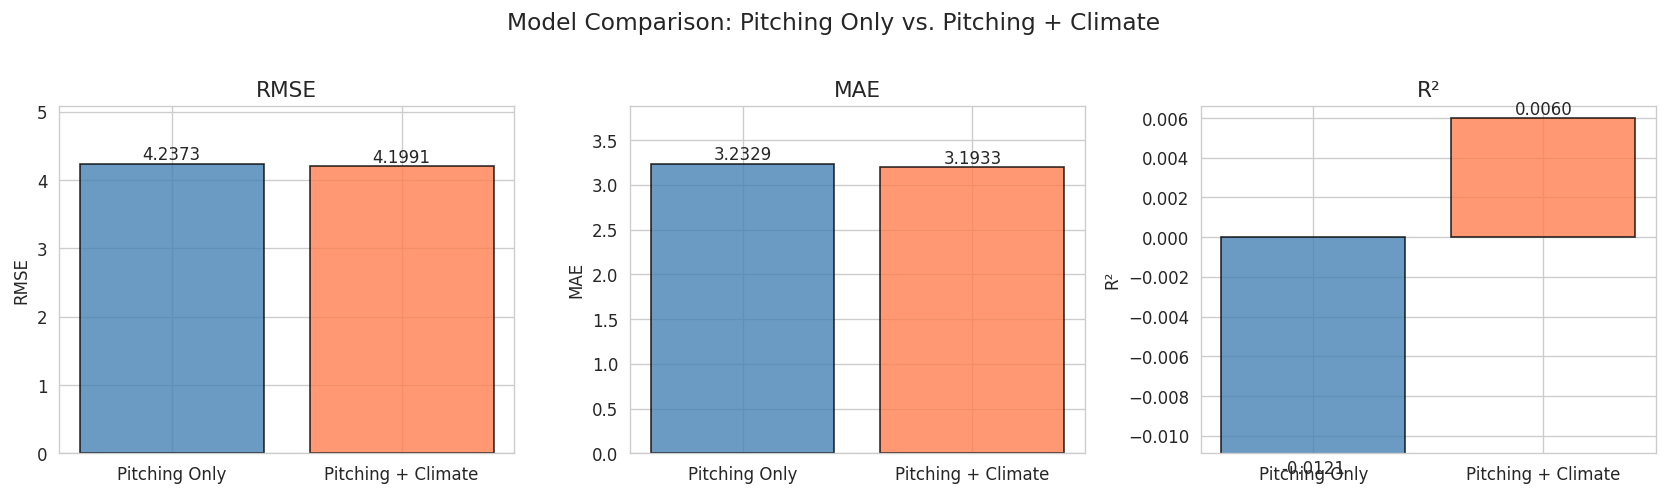

In [106]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

metrics_names = ["RMSE", "MAE", "R²"]
colors = ["steelblue", "coral"]
model_names = ["Pitching Only", "Pitching + Climate"]

for ax, metric in zip(axes, metrics_names):
    values = [results.loc["A: Pitching Only", metric],
              results.loc["B: Pitching + Climate", metric]]
    bars = ax.bar(model_names, values, color=colors, edgecolor="black", alpha=0.8)

    # Add value labels on bars
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                f"{val:.4f}", ha="center", va="bottom", fontsize=10)

    ax.set_title(metric, fontsize=13)
    ax.set_ylabel(metric)

    # For RMSE and MAE, lower is better. For R², higher is better.
    if metric in ["RMSE", "MAE"]:
        ax.set_ylim(0, max(values) * 1.2)
    else:
        ax.set_ylim(min(values) * 0.9, max(values) * 1.1)

fig.suptitle("Model Comparison: Pitching Only vs. Pitching + Climate", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


### Feature Importance
XGBoost's feature importance tells us which features the model relied on most. We can observe where the climate features fall in the rank of importance compared to pitching stats.

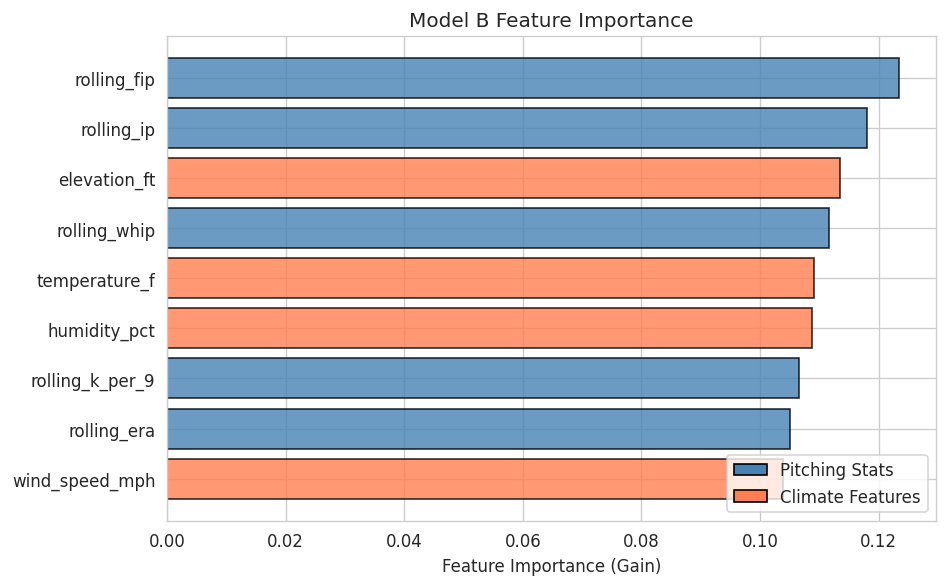

In [107]:
importance = model_b.feature_importances_
feature_names = features_b

importance_df = (
    pd.DataFrame({"feature": feature_names, "importance": importance})
    .sort_values("importance", ascending=True)
)

# Color climate features differently
colors = ["coral" if f in climate_features else "steelblue"
          for f in importance_df["feature"]]

fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(importance_df["feature"], importance_df["importance"],
        color=colors, edgecolor="black", alpha=0.8)
ax.set_xlabel("Feature Importance (Gain)")
ax.set_title("Model B Feature Importance")

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor="steelblue", edgecolor="black", label="Pitching Stats"),
                   Patch(facecolor="coral", edgecolor="black", label="Climate Features")]
ax.legend(handles=legend_elements, loc="lower right")

plt.tight_layout()
plt.show()


### Prediction vs. Actual
This scatter plot shows the predicted vs. actual ERA visualizes the model quality. Diagonal points indicate accurate predictions. We will plot model B.

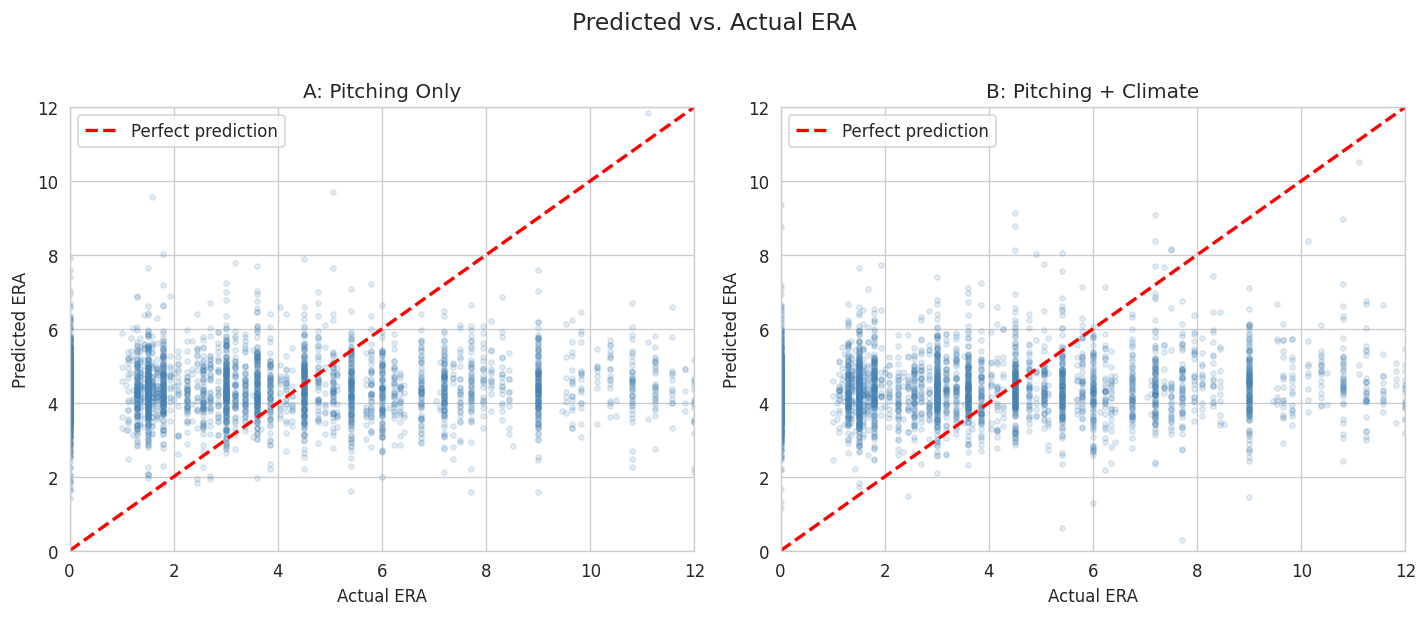

In [108]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, preds, name in zip(axes, [preds_a, preds_b],
                            ["A: Pitching Only", "B: Pitching + Climate"]):
    ax.scatter(y_test, preds, alpha=0.15, s=10, color="steelblue")

    # Perfect prediction line
    min_val = min(y_test.min(), preds.min())
    max_val = max(y_test.max(), preds.max())
    ax.plot([min_val, max_val], [min_val, max_val],
            color="red", linewidth=2, linestyle="--", label="Perfect prediction")

    ax.set_xlabel("Actual ERA")
    ax.set_ylabel("Predicted ERA")
    ax.set_title(name)
    ax.legend()
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 12)

fig.suptitle("Predicted vs. Actual ERA", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

### Residual Analysis
We can examine the resiudals (actual - predicted) to check for bias. A good model should have residuals centered around zero with no obvious patterns.

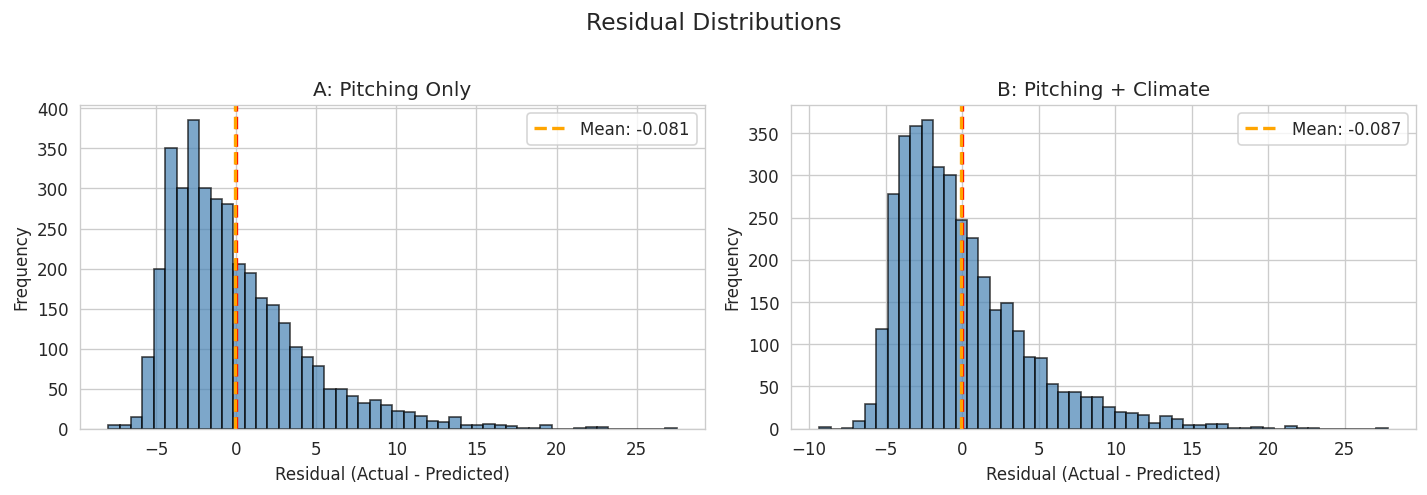

Model A residual std: 4.237
Model B residual std: 4.199


In [109]:
residuals_a = y_test - preds_a
residuals_b = y_test - preds_b

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, resid, name in zip(axes, [residuals_a, residuals_b],
                            ["A: Pitching Only", "B: Pitching + Climate"]):
    ax.hist(resid, bins=50, edgecolor="black", alpha=0.7, color="steelblue")
    ax.axvline(0, color="red", linewidth=2, linestyle="--")
    ax.axvline(resid.mean(), color="orange", linewidth=2, linestyle="--",
               label=f"Mean: {resid.mean():.3f}")
    ax.set_xlabel("Residual (Actual - Predicted)")
    ax.set_ylabel("Frequency")
    ax.set_title(name)
    ax.legend()

fig.suptitle("Residual Distributions", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

print(f"Model A residual std: {residuals_a.std():.3f}")
print(f"Model B residual std: {residuals_b.std():.3f}")

### Learning Curve
We can visualize a learning curve that shows if additional data would improve the model performance. We gradually train Model B on increasing segments of training data and plot both training and validation error. A decreasing validation curve at 100% of training data then the model would benifit form more observations

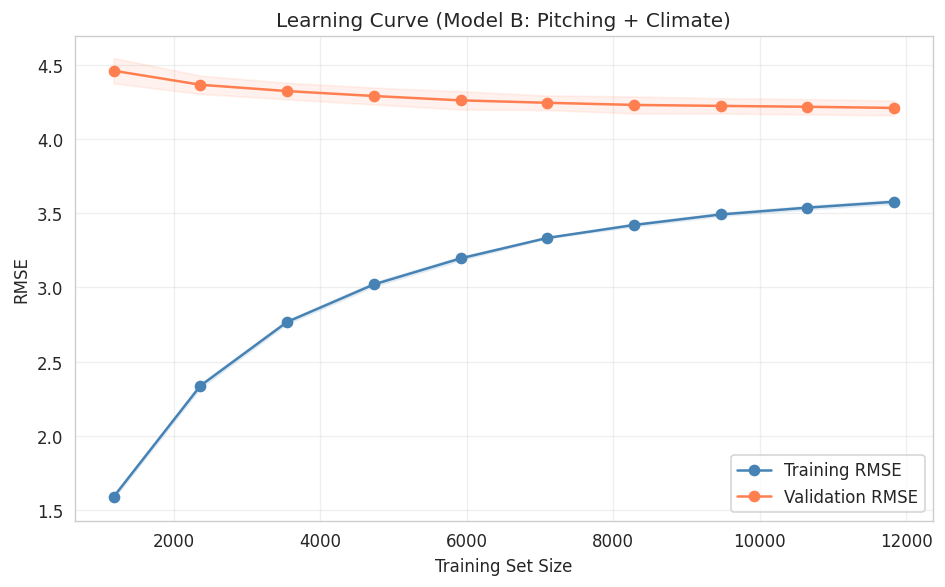

Final training RMSE: 3.5778
Final validation RMSE: 4.2104
Gap: 0.6326


In [110]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    XGBRegressor(**xgb_params),
    X_train[features_b],
    y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    random_state=42,
)

# Convert negative RMSE to positive
train_rmse = -train_scores.mean(axis=1)
val_rmse = -val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(train_sizes, train_rmse, "o-", color="steelblue", label="Training RMSE")
ax.fill_between(train_sizes, train_rmse - train_std, train_rmse + train_std,
                alpha=0.1, color="steelblue")

ax.plot(train_sizes, val_rmse, "o-", color="coral", label="Validation RMSE")
ax.fill_between(train_sizes, val_rmse - val_std, val_rmse + val_std,
                alpha=0.1, color="coral")

ax.set_xlabel("Training Set Size")
ax.set_ylabel("RMSE")
ax.set_title("Learning Curve (Model B: Pitching + Climate)")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final training RMSE: {train_rmse[-1]:.4f}")
print(f"Final validation RMSE: {val_rmse[-1]:.4f}")
print(f"Gap: {val_rmse[-1] - train_rmse[-1]:.4f}")

#8. Conclusion

## Evaluation Summary

We trained two XGBoost regression models to predict per-game pitcher ERA across 4 MLB seasons (2022-2025):

| Model | Features | RMSE | MAE | R² |
|-------|----------|------|-----|----|
| **A: Pitching Only** | Rolling ERA, K/9, WHIP, FIP, IP | 4.2373 | 3.2329 | -0.0121 |
| **B: Pitching + Climate** | Above + Temperature, Humidity, Wind Speed, Elevation | 4.1991 | 3.1933 | 0.0060 |
Adding climate features resulted in a **-0.9011% change in RMSE** and an
**R² change of 149.5542%** compared to the pitching-only baseline.

In [111]:
summary = pd.DataFrame({
    "Metric": ["RMSE", "MAE", "R²"],
    "Pitching Only": [
        np.sqrt(mean_squared_error(y_test, preds_a)),
        mean_absolute_error(y_test, preds_a),
        r2_score(y_test, preds_a),
    ],
    "Pitching + Climate": [
        np.sqrt(mean_squared_error(y_test, preds_b)),
        mean_absolute_error(y_test, preds_b),
        r2_score(y_test, preds_b),
    ],
}).set_index("Metric")

summary["Δ (B - A)"] = summary["Pitching + Climate"] - summary["Pitching Only"]
summary["% Change"] = ((summary["Pitching + Climate"] - summary["Pitching Only"])
                        / summary["Pitching Only"].abs() * 100)

summary.round(4)

,Pitching Only,Pitching + Climate,Δ (B - A),% Change
Metric,,,,
RMSE,4.2373,4.1991,-0.0382,-0.9011
MAE,3.2329,3.1933,-0.0396,-1.2261
R²,-0.0121,0.0060,0.0182,149.5542


In [113]:
# Quantify how much importance the model assigns to climate vs pitching
pitching_importance = sum(
    imp for feat, imp in zip(features_b, model_b.feature_importances_)
    if feat in pitching_features
)
climate_importance = sum(
    imp for feat, imp in zip(features_b, model_b.feature_importances_)
    if feat in climate_features
)

total = pitching_importance + climate_importance

print(f"Feature importance share:")
print(f"  Pitching stats: {pitching_importance / total * 100:.1f}%")
print(f"  Climate features: {climate_importance / total * 100:.1f}%")
print(f"\nClimate feature breakdown:")
for feat, imp in sorted(
    zip(features_b, model_b.feature_importances_),
    key=lambda x: x[1], reverse=True
):
    if feat in climate_features:
        print(f"  {feat}: {imp / total * 100:.1f}%")

Feature importance share:
  Pitching stats: 56.5%
  Climate features: 43.5%

Climate feature breakdown:
  elevation_ft: 11.4%
  temperature_f: 10.9%
  humidity_pct: 10.9%
  wind_speed_mph: 10.4%


### Question
*Can we improve MLB pitcher ERA predictions by incorporating game-day weather conditions alongside traditional pitching statistics?*

### Findings

**1. Pitching history is the dominant predictor.** Rolling ERA, FIP, WHIP, and K/9 are the largest factors involved with the models prediction. This is expected as it is traditionally how professional MLB analysts have made their predictions.

**2. Climate features provide modest contribution to the prediction model.** Adding temperature, humidity, wind speed, and elevation to the model changed RMSE by -0.9011% and R² by 149.5542%. Elevation contributed the most due to the Coors Field air being thinner where the air at this altitude reduced pitch movement and increase ball carry.

**3. Single-game ERA is inherently noisy.** Even an increase in data and more refined features would struggle to perfectly predict a pitcher's ERA for one game. Fluctuating factors like opponent lineup, umpire strikezone discretion, defense quality introduce variance that pitching history and climate can not predict.

### Limitations

- **Wind direction** is neglected. Headwinds suppress ball carry while tailwinds increase it and depending on the direction of the park's outfield fence can greatly improve or worsen player performance.
- **Rolling stats are noisy early in the season.** A pitchers first few games have limited historical data to make predictions on so the early averages will be noisy.
- **FIP constant** was approximated at 3.17 across all four seasons by it should be computed by per season from league totals.


### Tools & Technologies

| Category | Tools |
|----------|-------|
| **Language** | Python 3.10+ |
| **ML** | XGBoost, scikit-learn |
| **Data** | pandas, NumPy |
| **Visualization** | matplotlib, seaborn |
| **Data Sources** | MLB Stats API, Open-Meteo Archive API |
| **Statistical Testing** | SciPy (Welch's t-test), statsmodels (power analysis) |